<a href="https://colab.research.google.com/github/ahmetezzgi/BrainMRI_Classification/blob/main/BrainMRI_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -O brain_tumor_dataset.zip https://figshare.com/ndownloader/articles/1512427/versions/5

--2022-09-13 17:21:51--  https://figshare.com/ndownloader/articles/1512427/versions/5
Resolving figshare.com (figshare.com)... 52.30.192.85, 34.248.162.129, 2a05:d018:1f4:d003:ee55:4730:419:ad5b, ...
Connecting to figshare.com (figshare.com)|52.30.192.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 879501695 (839M) [application/zip]
Saving to: ‘brain_tumor_dataset.zip’

brain_tumor_dataset 100%[===================>] 838.76M  10.0MB/s    in 84s     

2022-09-13 17:23:17 (9.98 MB/s) - ‘brain_tumor_dataset.zip’ saved [879501695/879501695]



In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as op
op.download("https://www.kaggle.com/datasets/sinamhd9/chexnet-weights")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ahmetezgi
Your Kaggle Key: ··········


100%|██████████| 25.4M/25.4M [00:01<00:00, 17.8MB/s]


In [ ]:
!unzip brain_tumor_dataset.zip

Archive:  brain_tumor_dataset.zip
 extracting: brainTumorDataPublic_1-766.zip  
 extracting: brainTumorDataPublic_1533-2298.zip  
 extracting: brainTumorDataPublic_767-1532.zip  
 extracting: brainTumorDataPublic_2299-3064.zip  
 extracting: cvind.mat               
 extracting: README.txt              


In [ ]:
!mkdir brain_tumor_dataset

In [ ]:
!unzip brainTumorDataPublic_1-766.zip -d brain_tumor_dataset
!unzip brainTumorDataPublic_1533-2298.zip -d brain_tumor_dataset
!unzip brainTumorDataPublic_767-1532.zip -d brain_tumor_dataset
!unzip brainTumorDataPublic_2299-3064.zip -d brain_tumor_dataset

Archive:  brainTumorDataPublic_1-766.zip
  inflating: brain_tumor_dataset/1.mat  
  inflating: brain_tumor_dataset/10.mat  
  inflating: brain_tumor_dataset/100.mat  
  inflating: brain_tumor_dataset/101.mat  
  inflating: brain_tumor_dataset/102.mat  
  inflating: brain_tumor_dataset/103.mat  
  inflating: brain_tumor_dataset/104.mat  
  inflating: brain_tumor_dataset/105.mat  
  inflating: brain_tumor_dataset/106.mat  
  inflating: brain_tumor_dataset/107.mat  
  inflating: brain_tumor_dataset/108.mat  
  inflating: brain_tumor_dataset/109.mat  
  inflating: brain_tumor_dataset/11.mat  
  inflating: brain_tumor_dataset/110.mat  
  inflating: brain_tumor_dataset/111.mat  
  inflating: brain_tumor_dataset/112.mat  
  inflating: brain_tumor_dataset/113.mat  
  inflating: brain_tumor_dataset/114.mat  
  inflating: brain_tumor_dataset/115.mat  
  inflating: brain_tumor_dataset/116.mat  
  inflating: brain_tumor_dataset/117.mat  
  inflating: brain_tumor_dataset/118.mat  
  inflating: brai

In [ ]:
!pip install pymatreader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
from pymatreader import read_mat
import cv2
from sklearn.model_selection import train_test_split
from keras.applications import densenet
from keras.initializers import GlorotNormal

In [ ]:
class Brain_Tumor:
  def __init__(self, epochs, 
               batch_size, 
               dataset_folder,
               optimizer,
               loss):
    self.epochs = epochs
    self.batch_size = batch_size
    self.dataset_folder = dataset_folder
    self.optimizer = optimizer
    self.loss = loss
    self.DatasetFiles = list(pathlib.Path(os.path.join(self.dataset_folder)).glob("*.*"))
    self.classes = ["meningioma", "glioma","pituitary"]
  def read_mat_file(self, 
                    single_file):
    return read_mat(os.path.join(single_file))
  def plot_some_dataset_images(self,
                               number_of_image):
    plt.figure(figsize = (20, 8))
    for i in range(number_of_image):
      mat_obj = self.read_mat_file(self.DatasetFiles[i])
      plt.subplot(2, 4, i + 1)
      img = mat_obj['cjdata']['image']
      label = int(mat_obj['cjdata']['label'])
      plt.imshow(img)
      plt.title(self.classes[label - 1])
    plt.show()
  def collect_features_labels(self):
    images = []
    labels = []
    for single_file in self.DatasetFiles:
      mat_obj = self.read_mat_file(single_file)
      img = mat_obj['cjdata']['image']
      img = img/255
      img = np.float32(img)
      img = cv2.resize(img, (224, 224))
      img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
      img = img - np.mean(img)
      img = img/np.std(img)
      lab = int(mat_obj['cjdata']['label'])
      images.append(img)
      labels.append(lab)
    self.images = np.asarray(images)
    self.labels = np.asarray(labels)
  def DataAugmentation_Object(self):
    return tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=0.2,
        zoom_range=0.01,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=None)
  def augmentated_images(self):
    images_after_aug = []
    labels_after_aug = []
    augmentation_object = self.DataAugmentation_Object()
    for index, image in enumerate(self.images):
      for i in range(3):
          img = augmentation_object.flow(np.reshape(image, (1, 224, 224, 3))).next()
          images_after_aug.append(np.reshape(img, (224, 224, 3)))
          labels_after_aug.append(self.labels[index])
    self.labels = np.asarray(labels_after_aug)
    self.images = np.asarray(images_after_aug)
  def to_categorical_label(self):
    self.labels = self.labels - 1
    self.labels = tf.keras.utils.to_categorical(self.labels, num_classes = 3)
  def train_test_split(self, test_size):
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.images, 
                                                        self.labels, 
                                                        random_state = 42, 
                                                        test_size = test_size)
  def Model(self):
    d = densenet.DenseNet121(weights=None, include_top = False, input_shape = (224, 224, 3))
    m = tf.keras.layers.Dropout(0.8)(d.output)
    m = tf.keras.layers.GlobalAveragePooling2D(name = "GlobalAveragePooling2D_")(m)                         
    m = tf.keras.layers.Dropout(0.8)(m)
    m = tf.keras.layers.Dense(3, kernel_initializer=GlorotNormal(),
                              activation = 'softmax', kernel_regularizer= tf.keras.regularizers.L2(0.0001),
                              bias_regularizer= tf.keras.regularizers.L2(0.0001))(m)
    m = tf.keras.models.Model(inputs = d.input, outputs = m)
    m.load_weights("chexnet-weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5", by_name=True, skip_mismatch=True)
    for layer in m.layers[:200]:
        layer.trainable = False
    for layer in m.layers[200:]:
        layer.trainable = True
    self.m = m
  def compile(self):
    self.m.compile(optimizer = self.optimizer
          , loss = self.loss, metrics = ['accuracy'])
  def fit_model(self):
    self.history = self.m.fit(self.X_train, self.y_train, epochs = self.epochs, batch_size = self.batch_size,
                validation_data = (self.X_test, self.y_test),
                callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, mode = 'min',
                                                  patience= 2),
                             tf.keras.callbacks.EarlyStopping(patience = 14, monitor = 'val_loss', mode = 'min', restore_best_weights=True)])

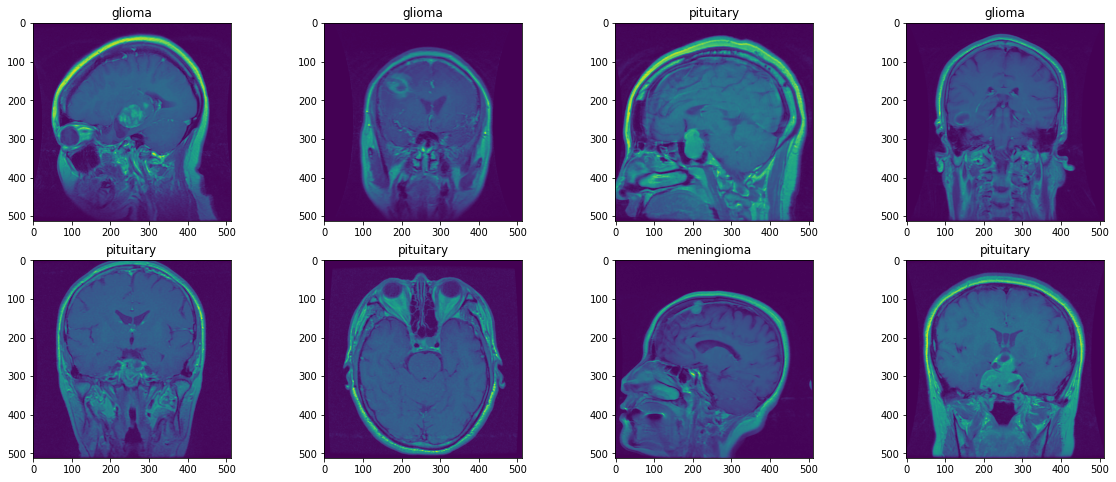

In [ ]:
Brain_Tumor_obj = Brain_Tumor(25, 
                              2, 
                              'brain_tumor_dataset', 
                              tf.keras.optimizers.Adam(0.001), 
                              'categorical_crossentropy')
Brain_Tumor_obj.plot_some_dataset_images(8)

In [ ]:
Brain_Tumor_obj.collect_features_labels()

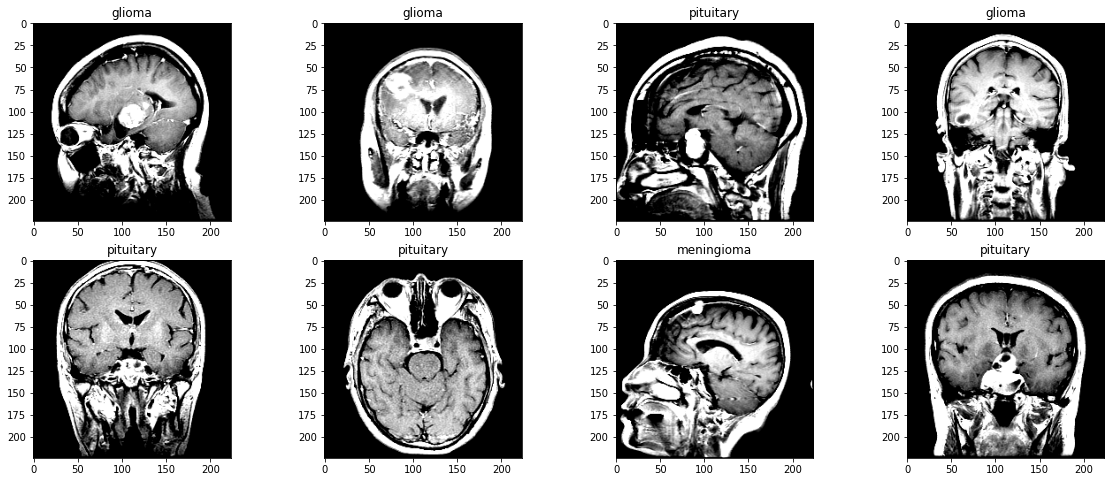

In [ ]:
plt.figure(figsize = (20, 8))
for i in range(8):
  plt.subplot(2, 4, i+ 1)
  plt.imshow(Brain_Tumor_obj.images[i])
  plt.title(Brain_Tumor_obj.classes[Brain_Tumor_obj.labels[i] - 1])
plt.show()

In [ ]:
Brain_Tumor_obj.augmentated_images()

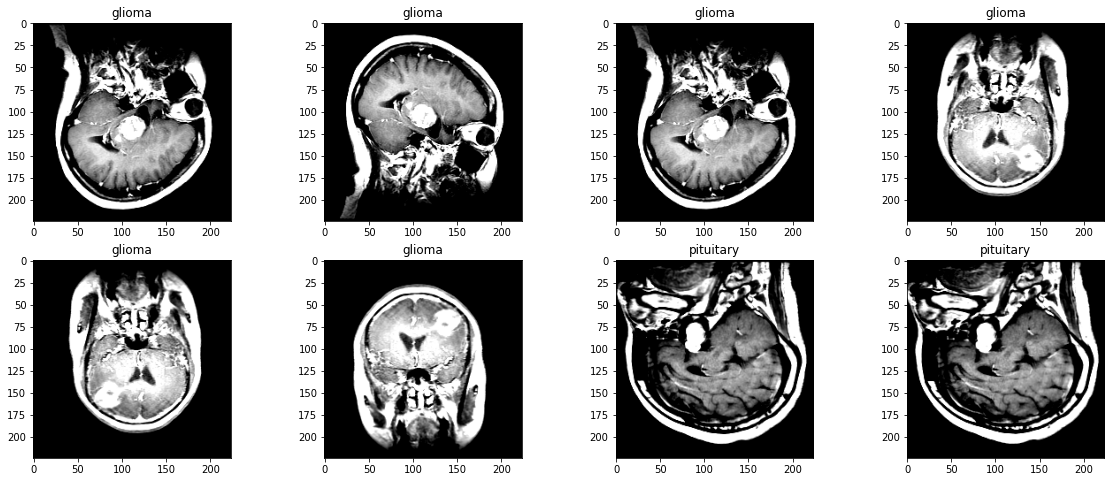

In [ ]:
plt.figure(figsize = (20, 8))
for i in range(8):
  plt.subplot(2, 4, i + 1)
  plt.imshow(Brain_Tumor_obj.images[i])
  plt.title(Brain_Tumor_obj.classes[Brain_Tumor_obj.labels[i] - 1])
plt.show()

In [ ]:
Brain_Tumor_obj.to_categorical_label()

In [ ]:
Brain_Tumor_obj.train_test_split(0.1)

In [ ]:
Brain_Tumor_obj.Model()
Brain_Tumor_obj.compile()
Brain_Tumor_obj.fit_model()

Epoch 1/25
4136/4136 [==============================] - 205s 45ms/step - loss: 0.9416 - accuracy: 0.6087 - val_loss: 0.3447 - val_accuracy: 0.8870 - lr: 0.0010
Epoch 2/25
4136/4136 [==============================] - 181s 44ms/step - loss: 0.5232 - accuracy: 0.7928 - val_loss: 0.3001 - val_accuracy: 0.8891 - lr: 0.0010
Epoch 3/25
4136/4136 [==============================] - 180s 43ms/step - loss: 0.3526 - accuracy: 0.8690 - val_loss: 0.1951 - val_accuracy: 0.9326 - lr: 0.0010
Epoch 4/25
4136/4136 [==============================] - 181s 44ms/step - loss: 0.2482 - accuracy: 0.9102 - val_loss: 0.1739 - val_accuracy: 0.9370 - lr: 0.0010
Epoch 5/25
4136/4136 [==============================] - 180s 44ms/step - loss: 0.1838 - accuracy: 0.9341 - val_loss: 0.1911 - val_accuracy: 0.9370 - lr: 0.0010
Epoch 6/25
4136/4136 [==============================] - 179s 43ms/step - loss: 0.1551 - accuracy: 0.9478 - val_loss: 0.1802 - val_accuracy: 0.9380 - lr: 0.0010
Epoch 7/25
4136/4136 [==================

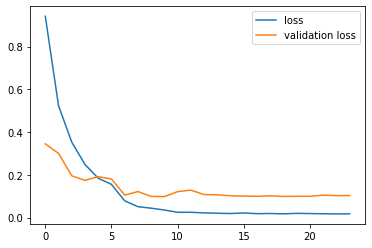

In [ ]:
plt.plot(Brain_Tumor_obj.history.history['loss'], label = "loss")
plt.plot(Brain_Tumor_obj.history.history['val_loss'], label = "validation loss")
plt.legend()

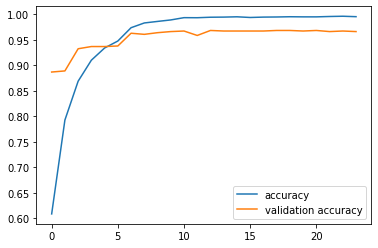

In [ ]:
plt.plot(Brain_Tumor_obj.history.history['accuracy'], label = "accuracy")
plt.plot(Brain_Tumor_obj.history.history['val_accuracy'], label = "validation accuracy")
plt.legend()